Agenda:
- 函数组合
- 机器学习pipeline
- 最近邻
- KNN分类器
- KNN回归器
- 欧式距离分数 Euclidean distance score
- 皮尔逊相关系属 Pearson correlation score
- 寻找数据集中的相似用户
- 生成电影推荐

推荐引擎通常用协同过滤(collaborative filtering)和基于内容的过滤(content-based filtering)来产生一组推荐

#### 函数组合
- pipeline不推荐使用嵌套和循环的方式调用这些函数，而是用函数式编程的方式构建函数组合

In [0]:
from functools import reduce
# 定义几个单独的函数和函数组合
import numpy as np

def add3(input_array):
    return map(lambda x: x+3, input_array)

def mul2(input_array):
    return map(lambda x: x*2, input_array)

def sub5(input_array):
    return map(lambda x: x-5, input_array)

# 定义一个函数组合器，用reduce函数依此组合所有函数
def function_composer(*args):
    return reduce(lambda f, g: lambda x: f(g(x)), args)

In [0]:
arr = np.array([2,5,4,7])

print("\nOperation: add3(mul2(sub5(arr)))")

arr1 = add3(arr)
arr2 = mul2(arr1)
arr3 = sub5(arr2)
print("Output using the lengthy way:", list(arr3))

func_composed = function_composer(sub5, mul2, add3)
print("Output using function composition:", list(func_composed(arr)))

print("\nOperation: sub5(add3(mul2(sub5(mul2(arr)))))\nOutput:", list(function_composer(mul2, sub5, mul2, add3, sub5)(arr)))


Operation: add3(mul2(sub5(arr)))
Output using the lengthy way: [5, 11, 9, 15]
Output using function composition: [5, 11, 9, 15]

Operation: sub5(add3(mul2(sub5(mul2(arr)))))
Output: [-10, 2, -2, 10]


#### 构建机器学习流水线
- 包括诸如预处理，特征选择，监督学习，非监督学习等函数
- 本例中包含输入特征向量、选择最好的k个特征、用随机森林分类器进行分类

In [0]:
from sklearn.datasets import _samples_generator
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

In [0]:
# generate sample data - 生成一个20维的分类样例数据
X, y = _samples_generator.make_classification(n_informative=4, n_features=20, n_redundant=0, random_state=5)
print(X[0:3])
print(y[0:3])

[[ 1.71357595  1.43919732 -0.52094767 -0.71371421  0.34400883  0.48570566
   0.40011155 -1.19072553 -1.53991349 -2.01425065  2.2903712  -0.34078422
   1.47493026 -1.58515839  1.17178634  1.15175458  0.29225066  0.27490402
   0.51469366  2.03968004]
 [-1.06488863 -0.39326245 -0.91041446  0.17067573  0.4609122   0.09995691
   0.90594214  0.00897802 -0.17459765 -1.59248747  1.08450045 -0.63820909
  -0.41670457 -1.26699367 -1.00728158 -2.00349031  1.39917318  0.04637225
  -0.28661553  0.69574385]
 [-0.89820155  0.01047972 -0.87577198  2.1029373  -0.38919996 -0.16645892
  -1.82821039 -0.37017317  0.41856503  1.91868897  0.24077181 -0.64706714
   1.52721195 -1.99953308 -1.68321585  0.90489823  1.43608356 -0.86316078
   1.54619738 -1.78406817]]
[1 1 0]


In [0]:
# Feature selector - 选择k个最好的特征. 
# F-value between label/feature for regression tasks. f_regression为回归问题筛选最佳特征，通过统计学指标返回p值。
# 原理是基于单变量的特征选择，进行单变量统计测试，从特征向量中抽取最优秀的特征。每一个特征会生成一个评价分数，以此来选择最好的k个特征。
selector_k_best = SelectKBest(f_regression, k=10)

# Random forest classifier
classifier = RandomForestClassifier(n_estimators=50, max_depth=4)

# Build the machine learning pipeline
pipeline_classifier = Pipeline([('selector', selector_k_best), ('rf', classifier)])

# We can set the parameters using the names we assigned
# earlier. For example, if we want to set 'k' to 6 in the
# feature selector and set 'n_estimators' in the Random 
# Forest Classifier to 25, we can do it as shown below
# ML pipeline的方法允许我们用预定义的方法来创建流水线
pipeline_classifier.set_params(selector__k=6, rf__n_estimators=25)

# Training the classifier
pipeline_classifier.fit(X, y)

# Predict the output - 预测输出结果
prediction = pipeline_classifier.predict(X)
print("\nPredictions:\n", prediction)

# Print score - 打印分类器得分，评价分类器性能
print("\nScore:", pipeline_classifier.score(X, y))                  

# Print the selected features chosen by the selector - 输出查看哪些特征被选中
features_status = pipeline_classifier.named_steps['selector'].get_support()
selected_features = []

for count, item in enumerate(features_status):
    if item:
        selected_features.append(count)

print("\nSelected features (0-indexed):", ', '.join([str(x) for x in selected_features]))


Predictions:
 [1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1
 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0 0 1
 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 1 1 0 1 1 0 1]

Score: 0.96

Selected features (0-indexed): 0, 5, 9, 10, 11, 15


#### 寻找K近邻

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

In [0]:
X = np.array([[1,1],[1,3],[2,2],[2.5,5],[3,1],[4,2],[2,3.5],[3,3],[3.5,4]])
X

Out[116]: array([[1. , 1. ],
       [1. , 3. ],
       [2. , 2. ],
       [2.5, 5. ],
       [3. , 1. ],
       [4. , 2. ],
       [2. , 3.5],
       [3. , 3. ],
       [3.5, 4. ]])


k nearest neighbors
1---> [2. 2.]
2---> [3. 1.]
3---> [3. 3.]
Out[117]: <matplotlib.collections.PathCollection at 0x7f2e8419ffd0>

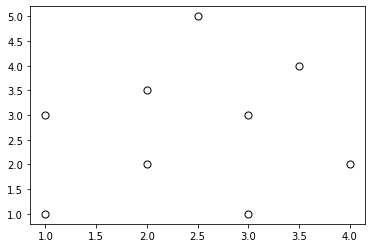

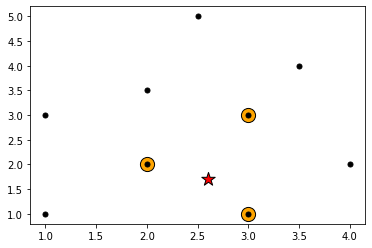

In [0]:
# 目标是找到任意给定点的几个最近邻
# 定义最近邻的数量
num_neighbors = 3

# 随机输入点
input_point = np.array([2.6,1.7]).reshape(-1,2)

# 输入数据可视化
plt.figure()
plt.scatter(X[:,0],X[:,1],marker='o',facecolor='white',s=50,color='k')

# 建立最近邻模型
knn = NearestNeighbors(n_neighbors=num_neighbors, algorithm='ball_tree').fit(X)

# 计算输入点和所有点的距离
distances, indices = knn.kneighbors(input_point)

# 打印出k个最近邻
print('\nk nearest neighbors')
for rank, index in enumerate(indices[0][:num_neighbors]):
    print(str(rank+1)+'--->',X[index])
    

# 画出输入测试数据点，并突出显示k个最近邻
plt.figure()

plt.scatter(X[indices][0][:][:,0],X[indices][0][:][:,1],marker='o',s=200,color='k',facecolors='orange')
plt.scatter(input_point[0][0] ,input_point[0][1], marker='*',s=200,color='k',facecolors='red')
plt.scatter(X[:,0], X[:,1], marker='o', s=25, color='k')

#### 构建一个KNN分类器
- 用k个最近邻来寻找未知对象分类的一种算法
- 以距离函数的形式来度量相似度指标
- 属于非参数化技术,进行计算前不需要照出任何隐含的参数,只需要确定k值
- 训练得到knn分类器后,便会做一个多数表决,进而确定分类类别

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import neighbors, datasets

In [0]:
# spark读取DBFS中txt文件
df = spark.read.text('/FileStore/tables/data_nn_classifier.txt')

# txt文件中所有数据会自动到dataframe中的一列
df1 = df.toPandas()

# 将txt中文本格式的数据，通过逗号来拆分开，并保留为string格式
expand_df = df1['value'].str.split(',', expand=True)

# 暴力字典法 - 批量遍历修改数据集的列名
new_dict = {key:'col'+'_'+str(i) for i, key in enumerate(expand_df.columns)}
expand_df.rename(columns=new_dict, inplace=True)

# str类型数据转化为numeric
lst_to_num = ['col_0', 'col_1', 'col_2']
for i in lst_to_num:
    expand_df[i] = pd.to_numeric(expand_df[i])
    
expand_df

print(expand_df.head())

   col_0  col_1  col_2
0   1.82   2.04      0
1   3.31   6.78      1
2   6.33   2.55      2
3   2.05   2.47      0
4   4.30   5.25      1


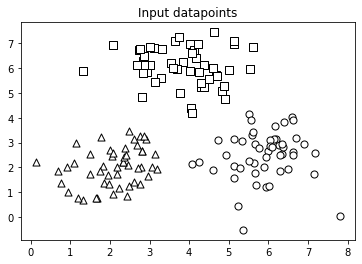

In [0]:
data = expand_df.copy()
X, y = np.array(data.iloc[:,:-1]), data.iloc[:,-1].astype(int)

# Plot input data
plt.figure()
plt.title('Input datapoints')
markers = '^sov<>hp'
mapper = np.array([markers[i] for i in y])
for i in range(X.shape[0]):
    plt.scatter(X[i, 0], X[i, 1], marker=mapper[i], 
            s=50, edgecolors='black', facecolors='white')

<command-2996851754775484>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x_grid, y_grid, predicted_values, cmap=cm.Pastel1)
Out[121]: Text(0.5, 1.0, 'k nearest neighbors classifier boundaries')

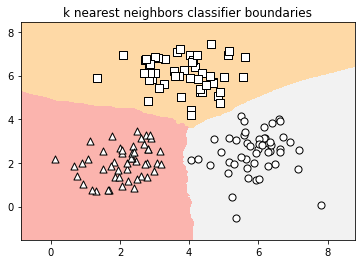

In [0]:
# 构建knn分类器
# Number of nearest neighbors to consider
num_neighbors = 10

# step size of the grid - 定义网格步长
h = 0.01  

# Create a K-Neighbours Classifier model and train it
classifier = neighbors.KNeighborsClassifier(num_neighbors, weights='distance')
classifier.fit(X, y)

# Create the mesh to plot the boundaries - 生成网格画出knn边界
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Compute the outputs for all the points on the mesh
predicted_values = classifier.predict(np.c_[x_grid.ravel(), y_grid.ravel()])

# Put the computed results on the map
predicted_values = predicted_values.reshape(x_grid.shape)
plt.figure()
plt.pcolormesh(x_grid, y_grid, predicted_values, cmap=cm.Pastel1)

# Overlay the training points on the map
for i in range(X.shape[0]):
    plt.scatter(X[i, 0], X[i, 1], marker=mapper[i], 
            s=50, edgecolors='black', facecolors='white')

plt.xlim(x_grid.min(), x_grid.max())
plt.ylim(y_grid.min(), y_grid.max())
plt.title('k nearest neighbors classifier boundaries')

Predicted output: 2


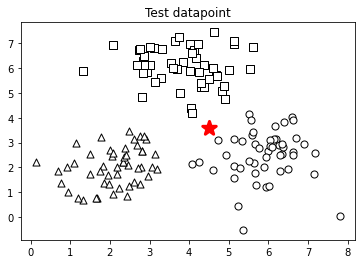

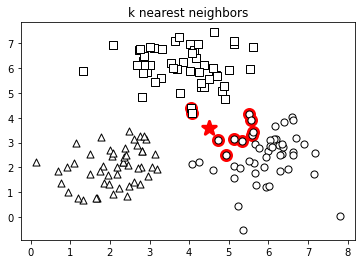

In [0]:
# Test input datapoint
test_datapoint = np.array([4.5, 3.6]).reshape(-1,2)

plt.figure()
plt.title('Test datapoint')
for i in range(X.shape[0]):
    plt.scatter(X[i, 0], X[i, 1], marker=mapper[i], 
            s=50, edgecolors='black', facecolors='white')

plt.scatter(test_datapoint[0][0], test_datapoint[0][1], marker='*', linewidth=3, s=200, facecolors='red')




# Extract k nearest neighbors - 提取测试点附近的最相邻的位置
dist, indices = classifier.kneighbors(test_datapoint)

# Plot k nearest neighbors
plt.figure()
plt.title('k nearest neighbors')

for i in indices:
    plt.scatter(X[i, 0], X[i, 1], marker='o', 
            linewidth=3, s=100, facecolors='red')

plt.scatter(test_datapoint[0][0], test_datapoint[0][1], marker='*',linewidth=3, s=200, facecolors='red')

for i in range(X.shape[0]):
    plt.scatter(X[i, 0], X[i, 1], marker=mapper[i], 
            s=50, edgecolors='black', facecolors='white')

print ("Predicted output:", classifier.predict(test_datapoint)[0])

plt.show()

#### KNN回归器

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import neighbors

Out[124]: Text(0.5, 1.0, 'Input data')

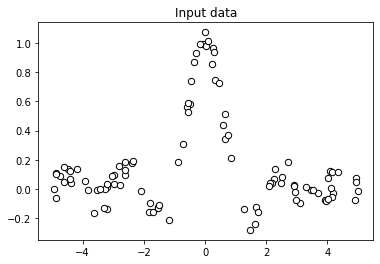

In [0]:
# Generate sample data - 生成样例数据
amplitude = 10
num_points = 100
X = amplitude * np.random.rand(num_points, 1) - 0.5 * amplitude

# Compute target and add noise - 加入一些噪音数据来测试算法的鲁棒性,能否忽略噪声.
y = np.sinc(X).ravel() 
y += 0.2 * (0.5 - np.random.rand(y.size))

# Plot input data
plt.figure()
plt.scatter(X, y, s=40, c='white', edgecolors='black')
plt.title('Input data')

Out[125]: Text(0.5, 1.0, 'K Nearest Neighbors Regressor')

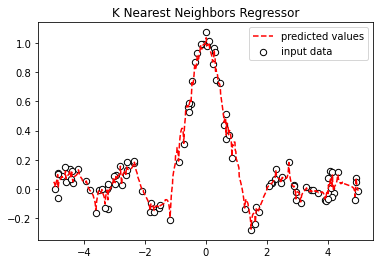

In [0]:
# 在上述输入数据的基础上,定义更密集的网格点. 通过这些网格点来评价回归器,并评价它和函数的相似程度. 用输入数据的10倍密度创建一堆网格. (本例实际上使用Sinc函数来掩饰KNN回归器, sinc(x) = sin(x)/x. Create the 1D grid with 10 times the density of the input data
x_values = np.linspace(-0.5*amplitude, 0.5*amplitude, 10*num_points)[:, np.newaxis]

# Number of neighbors to consider - 最近邻个数
n_neighbors = 10

# Define and train the regressor
knn_regressor = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')
y_values = knn_regressor.fit(X, y).predict(x_values)

# 可视化回归结果
plt.figure()
plt.plot(x_values, y_values, c='red', linestyle='--', label='predicted values')
plt.scatter(X, y, s=40, c='white',edgecolors='k', label='input data')

plt.xlim(X.min() - 1, X.max() + 1)
plt.ylim(y.min() - 0.2, y.max() + 0.2)
plt.axis('tight')
plt.legend()
# plt.grid()
plt.title('K Nearest Neighbors Regressor')

# plt.show()

#### 计算欧式距离分数
- 定义相似度指标,以便找到与特定用户相似的用户
- 构建一个推荐引擎,可以考虑计算两个用户间的欧几里得分数

In [0]:
# Json数据样例:
# {
#     "John Carson": 
#     {
#         "Inception": 2.5,
#         "Pulp Fiction": 3.5,
#         "Anger Management": 3.0,
#         "Fracture": 3.5,
#         "Serendipity": 2.5,
#         "Jerry Maguire": 3.0
#     },
#     "Michelle Peterson": 
#     {
#         "Inception": 3.0,
#         "Pulp Fiction": 3.5,
#         "Anger Management": 1.5,
#         "Fracture": 5.0,
#         "Jerry Maguire": 3.0,
#         "Serendipity": 3.5 
#     },

In [0]:
# 在本地Python环境中运行,不再测试spark读取json文件并解析
# import json
# import numpy as np
 
# # Returns the Euclidean distance score between user1 and user2 
# def euclidean_score(dataset, user1, user2):
#     if user1 not in dataset:
#         raise TypeError('User ' + user1 + ' not present in the dataset')

#     if user2 not in dataset:
#         raise TypeError('User ' + user2 + ' not present in the dataset')

#     # Movies rated by both user1 and user2
#     rated_by_both = {} 

#     for item in dataset[user1]:
#         if item in dataset[user2]:
#             rated_by_both[item] = 1

#     # If there are no common movies, the score is 0 
#     if len(rated_by_both) == 0:
#         return 0

#     squared_differences = [] 

#     for item in dataset[user1]:
#         if item in dataset[user2]:
#             squared_differences.append(np.square(dataset[user1][item] - dataset[user2][item]))
        
#     return 1 / (1 + np.sqrt(np.sum(squared_differences))) 

# if __name__=='__main__':
#     data_file = 'movie_ratings.json'

#     with open(data_file, 'r') as f:
#         data = json.loads(f.read())

#     user1 = 'John Carson'
#     user2 = 'Michelle Peterson'

#     print("\nEuclidean score:")
#     print(euclidean_score(data, user1, user2))

#### 计算皮尔逊相关系数
- 计算两个用户之间的相似度,同样用上例中的json文件,代码记录后不再运行

In [0]:
# import json
# import numpy as np

# # Returns the Pearson correlation score between user1 and user2 
# def pearson_score(dataset, user1, user2):
#     if user1 not in dataset:
#         raise TypeError('User ' + user1 + ' not present in the dataset')

#     if user2 not in dataset:
#         raise TypeError('User ' + user2 + ' not present in the dataset')

#     # Movies rated by both user1 and user2
#     rated_by_both = {}

#     for item in dataset[user1]:
#         if item in dataset[user2]:
#             rated_by_both[item] = 1

#     num_ratings = len(rated_by_both) 

#     # If there are no common movies, the score is 0 
#     if num_ratings == 0:
#         return 0

#     # Compute the sum of ratings of all the common preferences 
#     user1_sum = np.sum([dataset[user1][item] for item in rated_by_both])
#     user2_sum = np.sum([dataset[user2][item] for item in rated_by_both])

#     # Compute the sum of squared ratings of all the common preferences 
#     user1_squared_sum = np.sum([np.square(dataset[user1][item]) for item in rated_by_both])
#     user2_squared_sum = np.sum([np.square(dataset[user2][item]) for item in rated_by_both])

#     # Compute the sum of products of the common ratings 
#     product_sum = np.sum([dataset[user1][item] * dataset[user2][item] for item in rated_by_both])

#     # Compute the Pearson correlation
#     Sxy = product_sum - (user1_sum * user2_sum / num_ratings)
#     Sxx = user1_squared_sum - np.square(user1_sum) / num_ratings
#     Syy = user2_squared_sum - np.square(user2_sum) / num_ratings
    
#     if Sxx * Syy == 0:
#         return 0

#     return Sxy / np.sqrt(Sxx * Syy)

# if __name__=='__main__':
#     data_file = 'movie_ratings.json'

#     with open(data_file, 'r') as f:
#         data = json.loads(f.read())

#     user1 = 'John Carson'
#     user2 = 'Michelle Peterson'

#     print ("\nPearson score:")
#     print (pearson_score(data, user1, user2) )

#### 寻找数据集中的相似用户

In [0]:
# import json
# import numpy as np

# from pearson_score import pearson_score

# # Finds a specified number of users who are similar to the input user
# def find_similar_users(dataset, user, num_users):
#     if user not in dataset:
#         raise TypeError('User ' + user + ' not present in the dataset')

#     # Compute Pearson scores for all the users
#     scores = np.array([[x, pearson_score(dataset, user, x)] for x in dataset if user != x])

#     # Sort the scores based on second column
#     scores_sorted = np.argsort(scores[:, 1])

#     # Sort the scores in decreasing order (highest score first) 
#     scored_sorted_dec = scores_sorted[::-1]

#     # Extract top 'k' indices
#     top_k = scored_sorted_dec[0:num_users] 

#     return scores[top_k] 

# if __name__=='__main__':
#     data_file = 'movie_ratings.json'

#     with open(data_file, 'r') as f:
#         data = json.loads(f.read())

#     user = 'John Carson'
#     print "\nUsers similar to " + user + ":\n"
#     similar_users = find_similar_users(data, user, 3) 
#     print "User\t\t\tSimilarity score\n"
#     for item in similar_users:
#         print item[0], '\t\t', round(float(item[1]), 2)


#### 生成电影推荐
- 前面的例子已经创建了推荐引擎的各个部分,接下来组合成一个推荐系统

In [0]:
# import json
# import numpy as np

# from euclidean_score import euclidean_score
# from pearson_score import pearson_score
# from find_similar_users import find_similar_users
 
# # Generate recommendations for a given user
# def generate_recommendations(dataset, user):
#     if user not in dataset:
#         raise TypeError('User ' + user + ' not present in the dataset')

#     total_scores = {}
#     similarity_sums = {}

#     for u in [x for x in dataset if x != user]:
#         similarity_score = pearson_score(dataset, user, u)

#         if similarity_score <= 0:
#             continue

#         for item in [x for x in dataset[u] if x not in dataset[user] or dataset[user][x] == 0]:
#             total_scores.update({item: dataset[u][item] * similarity_score})
#             similarity_sums.update({item: similarity_score})

#     if len(total_scores) == 0:
#         return ['No recommendations possible']

#     # Create the normalized list
#     movie_ranks = np.array([[total/similarity_sums[item], item] 
#             for item, total in total_scores.items()])

#     # Sort in decreasing order based on the first column
#     movie_ranks = movie_ranks[np.argsort(movie_ranks[:, 0])[::-1]]

#     # Extract the recommended movies
#     recommendations = [movie for _, movie in movie_ranks]

#     return recommendations
 
# if __name__=='__main__':
#     data_file = 'movie_ratings.json'

#     with open(data_file, 'r') as f:
#         data = json.loads(f.read())

#     user = 'Michael Henry'
#     print "\nRecommendations for " + user + ":"
#     movies = generate_recommendations(data, user) 
#     for i, movie in enumerate(movies):
#         print str(i+1) + '. ' + movie

#     user = 'John Carson' 
#     print "\nRecommendations for " + user + ":"
#     movies = generate_recommendations(data, user) 
#     for i, movie in enumerate(movies):
#         print str(i+1) + '. ' + movie
